




## I ) Introduction



On dispose d'un jeu de données avec le relevé de 7999 eaux. 
On souhaite prédire la qualité de l'eau : "saine", "non saine". 

Dans un premier temps nous faisons une étude statistique des variables à disposition. Il s'agit ici de sélectionner nos variables pour entraîner les modèles de classification.
Nous comparerons la régression logistique, les arbres de décisions binaires, les random forest et les svm sur les données à disposition.
Pour finir, nous utiliserons les prédictions de chacune des méthodes pour construire un nouveau modèle de prédiction appelé superlearner.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
from summarytools import dfSummary
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


#data = pd.read_csv("/home/jeremy.lepeut.etu/Desktop/Methode/waterQuality.csv",decimal=".")
data = pd.read_csv(r"G:\\FAC\Methode Apprentissage\waterQuality.csv",decimal=".")
indexNames = data[data['ammonia'] =='#NUM!'].index
data.drop(indexNames,inplace=True)
data['ammonia'] = data['ammonia'].astype('float64')

X = data.drop(["is_safe"], axis=1)
Y = data["is_safe"].astype("category")

In [ ]:
#Courbe roc
def courbe_roc(Y_test,Proba,esti_name):
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,Proba,pos_label='1')
    roc_auc = metrics.auc(fpr,tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, 
                                tpr=tpr, 
                                roc_auc=roc_auc,
                                estimator_name=esti_name)
    display.plot()

#Matrice de confusion    
def  cm(x,y,titre):
    
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(x,y), annot=True, fmt='g', ax=ax);
    ax.set_xlabel('Catégorie prédite');ax.set_ylabel('Catégorie réelle'); 
    ax.set_title(titre); 

## II) Etude des données

On regarde les statistiques des variables à disposition. 

In [5]:
X.describe()

aluminium      ammonia      arsenic       barium      cadmium  \
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000   
mean      0.666396    14.278212     0.161477     1.567928     0.042803   
std       1.265323     8.878930     0.252632     1.216227     0.036049   
min       0.000000    -0.080000     0.000000     0.000000     0.000000   
25%       0.040000     6.577500     0.030000     0.560000     0.008000   
50%       0.070000    14.130000     0.050000     1.190000     0.040000   
75%       0.280000    22.132500     0.100000     2.482500     0.070000   
max       5.050000    29.840000     1.050000     4.940000     0.130000   

        chloramine     chromium       copper     flouride     bacteria  \
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000   
mean      2.177589     0.247300     0.805940     0.771646     0.319714   
std       2.567210     0.270663     0.653595     0.435423     0.329497   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.100000     0.050000     0.090000     0.407500     0.000000   
50%       0.530000     0.090000     0.750000     0.770000     0.220000   
75%       4.240000     0.440000     1.390000     1.160000     0.610000   
max       8.680000     0.900000     2.000000     1.500000     1.000000   

           viruses         lead     nitrates     nitrites      mercury  \
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000   
mean      0.328706     0.099431     9.819250     1.329846     0.005193   
std       0.378113     0.058169     5.541977     0.573271     0.002967   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.002000     0.048000     5.000000     1.000000     0.003000   
50%       0.008000     0.102000     9.930000     1.420000     0.005000   
75%       0.700000     0.151000    14.610000     1.760000     0.008000   
max       1.000000     0.200000    19.830000     2.930000     0.010000   

       perchlorate       radium     selenium       silver      uranium  
count  7996.000000  7996.000000  7996.000000  7996.000000  7996.000000  
mean     16.465266     2.920106     0.049684     0.147811     0.044672  
std      17.688827     2.322805     0.028773     0.143569     0.026906  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       2.170000     0.820000     0.020000     0.040000     0.020000  
50%       7.745000     2.410000     0.050000     0.080000     0.050000  
75%      29.487500     4.670000     0.070000     0.240000     0.070000  
max      60.010000     7.990000     0.100000     0.500000     0.090000

On ne garde pas la variable 'mercury' car sa variance est très petite, de l'ordre de 10^-6. 

On regarde maintenant les variables deux à deux, et l'on peut observer que certains couples de variables permettent d'observer des régions où sont présents les points jaunes, qui représentent les eaux saines.

L'idée est de séparer les points jaunes des points violets, de trouver les frontières séparant les eaux saines des non saines à partir des variables explicatives

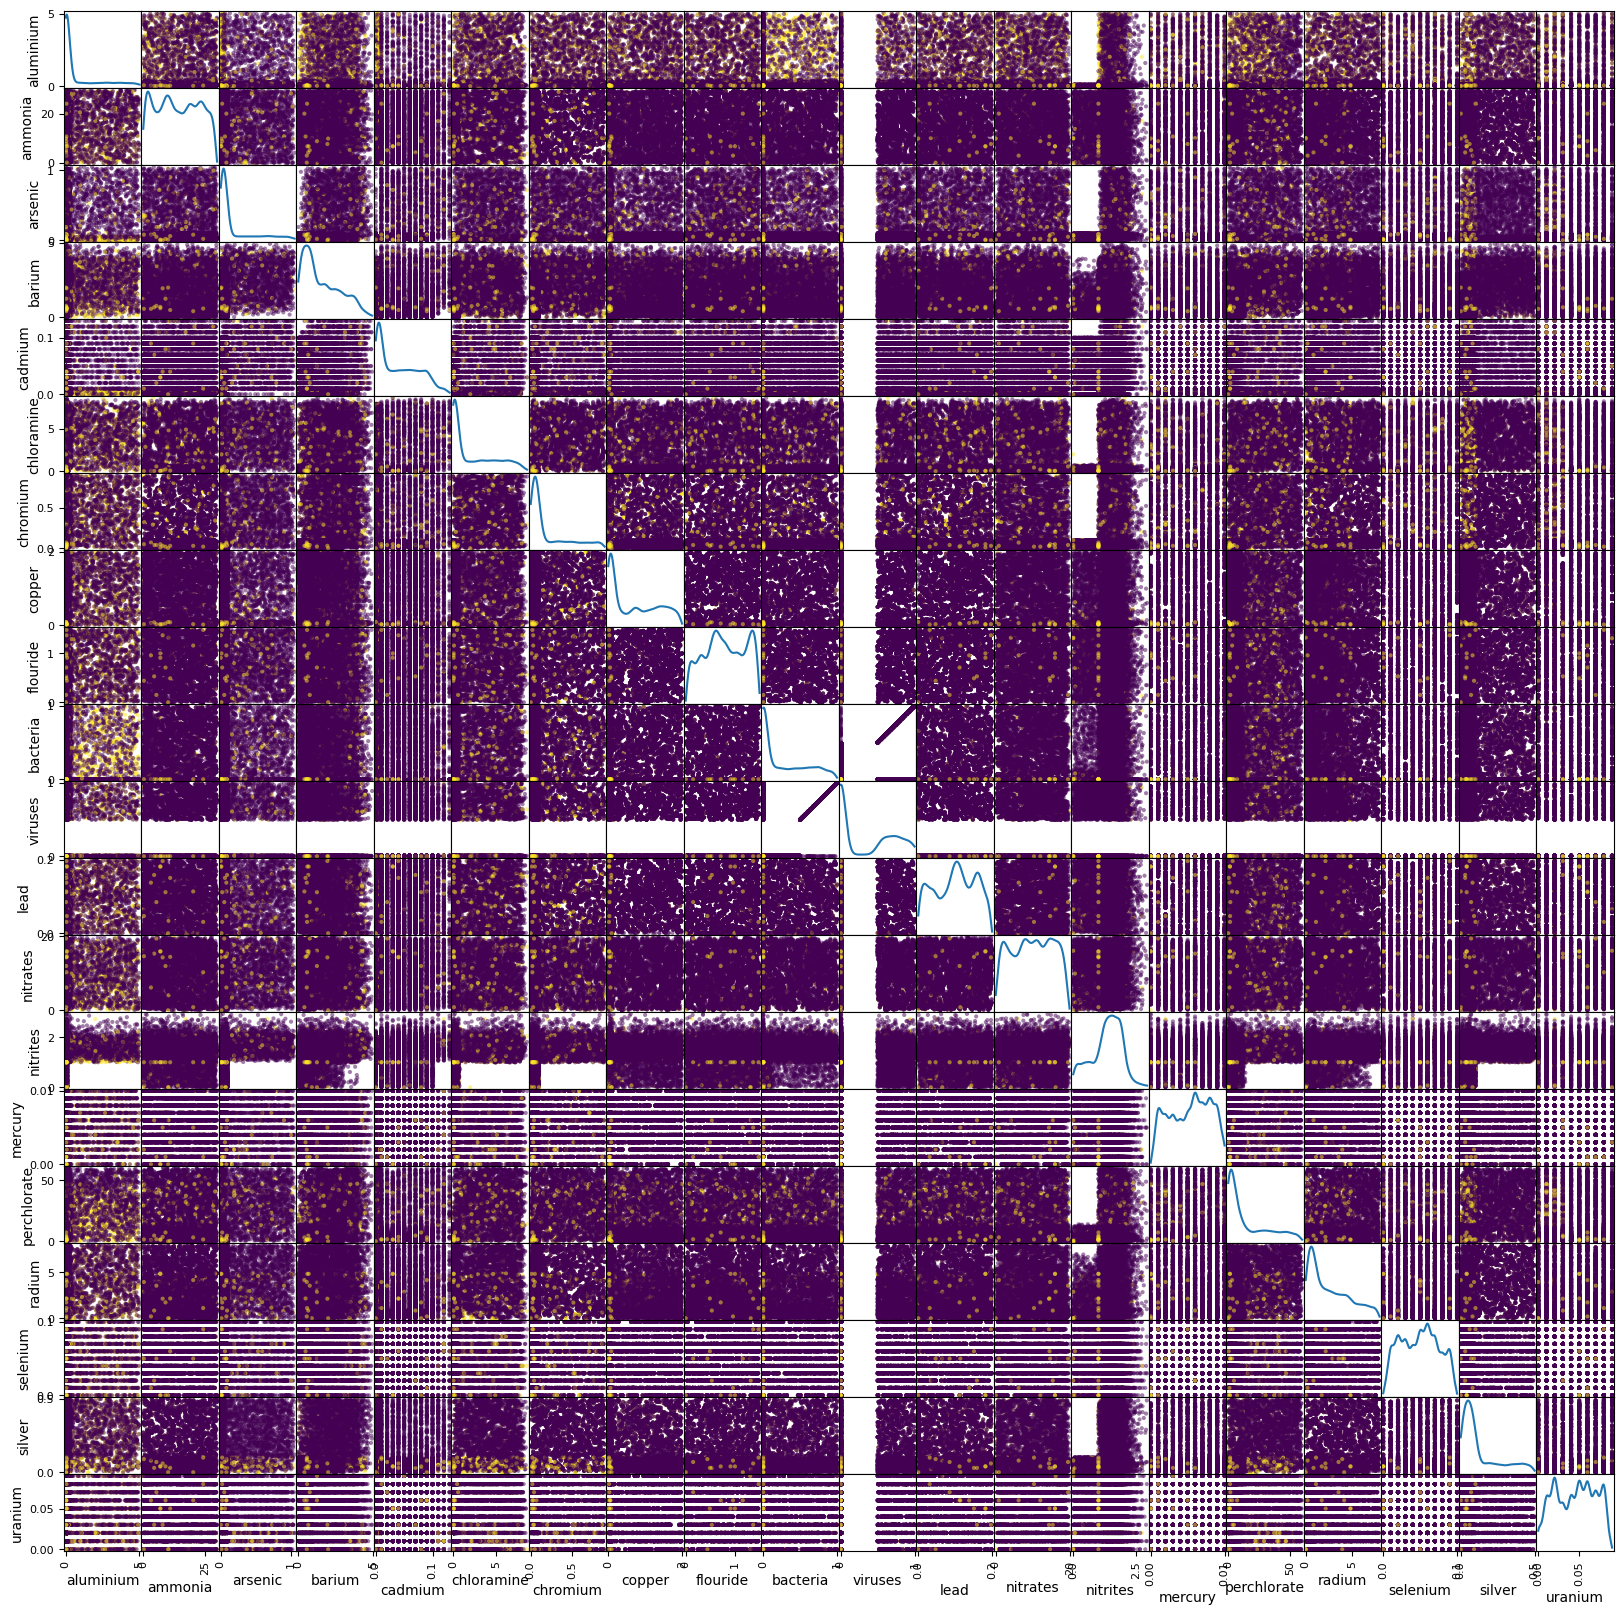

In [65]:
scatter_matrix(X,c=Y.astype("float64"), figsize = [20,20], marker = ".", diagonal= "kde") 
plt.show()

Pour la variable "Silver" (avant dernière ligne), on voit que la variable, couplée à l'aluminium, ou l'arsenic, ou bien la chloramine permet déjà de définir des régions où l'on observe des points jaunes, qui représentent les eaux saines.

### Histogramme 

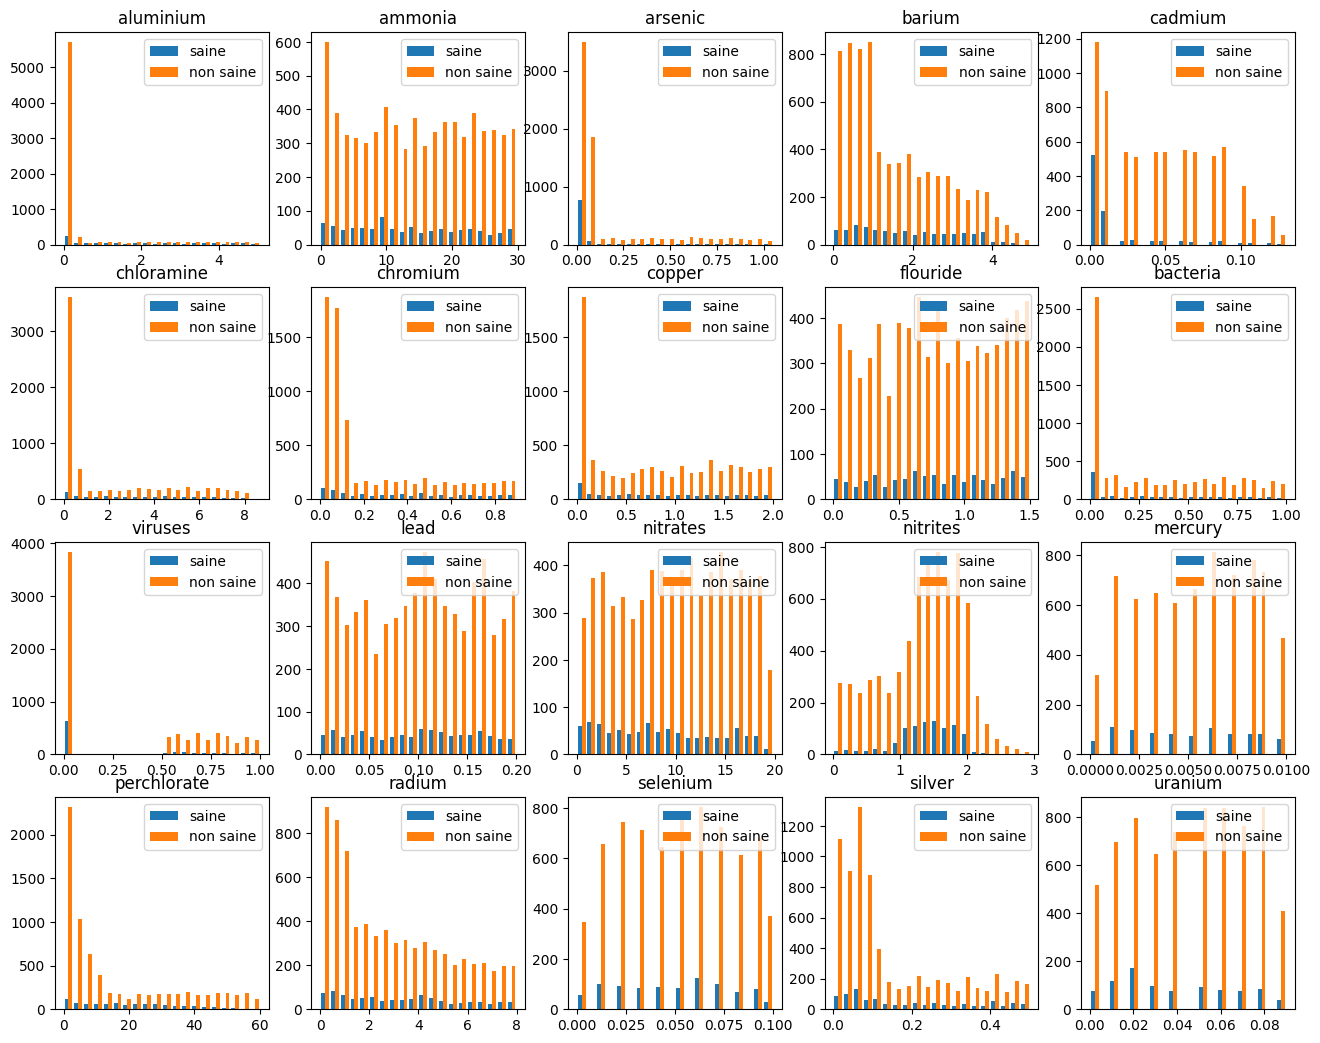

In [7]:
safe = data[data["is_safe"]=="1"]
not_safe = data[data["is_safe"]=="0"]


figure = plt.figure(figsize = (16, 16)) 
plt.figure(1)
for i in range(0,len(X.columns)):
    plt.subplot(5,5,i+1)
    plt.hist([safe.iloc[:,i],not_safe.iloc[:,i]],bins=20,histtype='bar')
    plt.title(X.columns[i])
    plt.legend(['saine', 'non saine'], loc = 'upper right')

On ne voit pas de séparation particulière des classes à partir des histogrammes des variables. C'est là que notre travail va être utile. 

On regarde maintenant la matrice de corrélation :

C:\Users\lepeu\AppData\Local\Temp\ipykernel_10540\1995017558.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(data.corr(), annot=True)


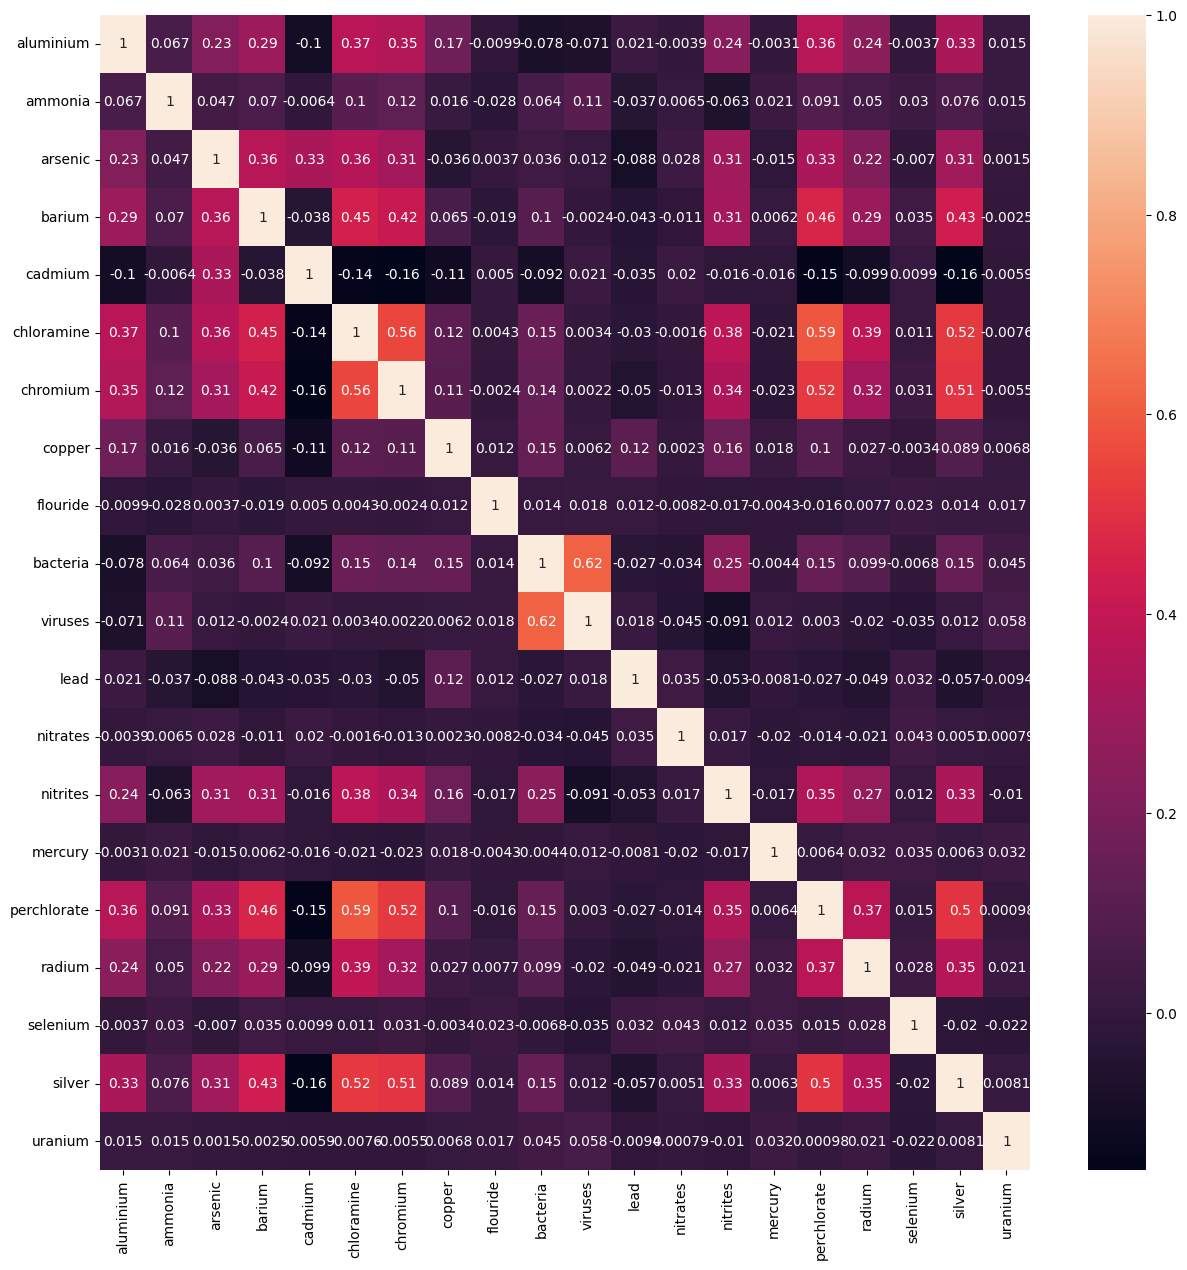

In [8]:
fig, ax = plt.subplots(figsize=(15,15))         
ax = sns.heatmap(data.corr(), annot=True)

On n'observe pas de grande corrélation entre les variables. On les garde toute pour l'entrainement des modèles.

On choisit maintenant de séparer en 2 nos données, afin de constituer un échantillon d'apprentissage, qui servira à calibrer le modèle, et un échantillon de test, qui permettra de vérifier la force de prédiction de notre modèle. 

In [59]:
X = X.drop(["mercury"], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20)

## III ) Régression logitistique

La régression logistique est souvent employée pour des problèmes de classification à 2 ou plusieurs classes.


In [34]:
model1 = LogisticRegression(random_state = 0, penalty = "none", fit_intercept = True, max_iter = 10000)
model1.fit(X_train,Y_train)

LogisticRegression(max_iter=10000, penalty='none', random_state=0)

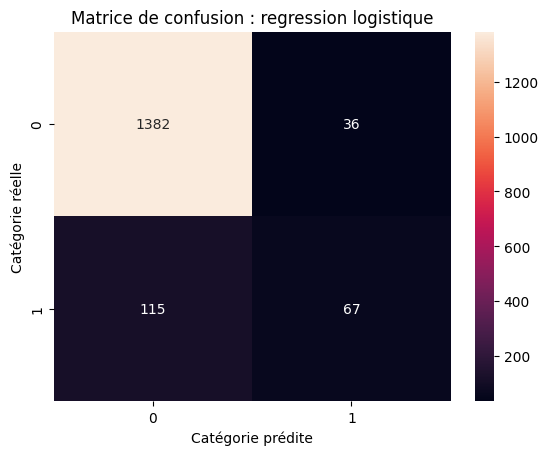

In [70]:
cm(Y_test,model1.predict(X_test),"Matrice de confusion : regression logistique")

La régression logistique a fait 146 erreurs sur l'échantillon de test qui a une taille de 1600 individus.
On veut connaitre les odds ratios, on regarde pour cela les coefficients de la régression logistique.

In [61]:
#Obtenir les odds ratio avec les variables
c = []
for i in range(0,len(model1.coef_)-1):
    c.append(math.exp(model1.coef_[:,i]))

coef = pd.DataFrame(model1.coef_)
df = pd.DataFrame(X.columns , coef.apply(lambda x : math.exp(x)))
df

0
2.037097e+00    aluminium
9.735498e-01      ammonia
5.139528e-02      arsenic
1.122117e+00       barium
1.100953e-09      cadmium
1.197138e+00   chloramine
3.253791e+00     chromium
6.695248e-01       copper
1.131440e+00     flouride
2.165536e+00     bacteria
2.939507e-01      viruses
2.458753e-01         lead
9.532165e-01     nitrates
7.319887e-01     nitrites
9.758619e-01  perchlorate
9.423905e-01       radium
1.069636e-02     selenium
2.406866e-01       silver
4.522069e-07      uranium

En regardant les valeurs des coefficients, on peut dire que plus la concentration en aluminium, en chloramine, en chromium, en bactérie est grande, plus de chance a notre eau d'être saine.
Pour la concentration en aluminium, on a deux fois plus de chance d'obtenir une eau saine qu'une eau non saine/potable. En effet, l'aluminium est utilisé en station d'épurations pour assainir l'eau.
De même, en présence de chromium, qui est un élément essentiel à l'homme, on a 3 fois plus de chance d'observer une eau saine.

### Courbe ROC

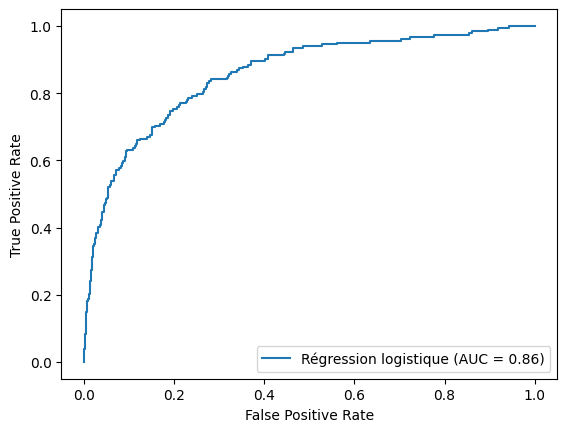

In [73]:
courbe_roc(Y_test,model1.predict_proba(X_test)[:,1],"Régression logistique")

# IV) Cart

Les méthodes CART sont des méthodes à séparation linéaire des données. A chaque étape, ils séparent le jeu de donnée en deux parties, selon un seuil d'une des variables explicative.
On détermine dans un premier temps la profondeur optimale pour l'arbre puis on l'entraine sur notre échantillon d'apprentissage.

### Hyperparamètres

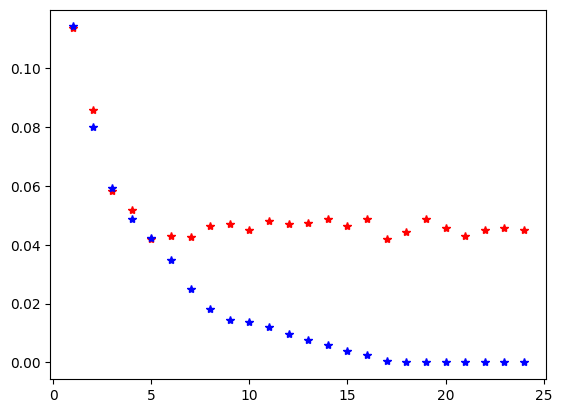

In [64]:
from sklearn.tree import DecisionTreeClassifier, plot_tree 

p_test = []
p_train = []

for i in np.arange(1,25):
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X_train,Y_train)
    p_test.append((Y_test != tree.predict(X_test)).mean())
    p_train.append((Y_train != tree.predict(X_train)).mean())


plt.plot(np.arange(1,25), p_test, "r*")
plt.plot(np.arange(1,25), p_train, "b*")


On choisit ici une profondeur de 6 pour notre arbre.

In [24]:
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=6)

[Text(298.48571428571427, 343.2, 'X[4] <= 0.009\ngini = 0.204\nsamples = 6396\nvalue = [5659, 737]'),
 Text(170.05714285714285, 290.4, 'X[0] <= 0.405\ngini = 0.437\nsamples = 1770\nvalue = [1199, 571]'),
 Text(95.65714285714286, 237.59999999999997, 'X[0] <= 0.155\ngini = 0.168\nsamples = 1035\nvalue = [939, 96]'),
 Text(56.68571428571428, 184.79999999999998, 'X[18] <= 0.035\ngini = 0.111\nsamples = 847\nvalue = [797, 50]'),
 Text(28.34285714285714, 131.99999999999997, 'X[17] <= 0.105\ngini = 0.216\nsamples = 332\nvalue = [291, 41]'),
 Text(14.17142857142857, 79.19999999999999, 'X[5] <= 0.68\ngini = 0.426\nsamples = 114\nvalue = [79, 35]'),
 Text(7.085714285714285, 26.399999999999977, 'gini = 0.067\nsamples = 58\nvalue = [56, 2]'),
 Text(21.257142857142856, 26.399999999999977, 'gini = 0.484\nsamples = 56\nvalue = [23, 33]'),
 Text(42.51428571428571, 79.19999999999999, 'X[9] <= 0.01\ngini = 0.054\nsamples = 218\nvalue = [212, 6]'),
 Text(35.42857142857143, 26.399999999999977, 'gini = 0.3

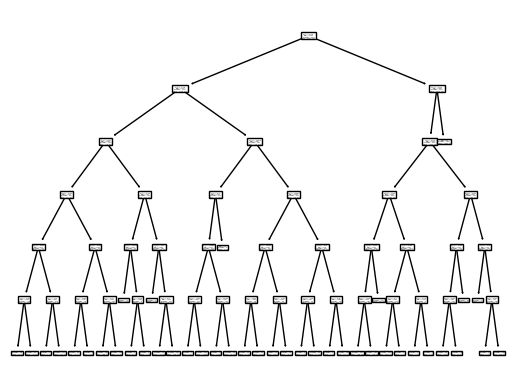

In [25]:
plot_tree(tree)

On peut voir ici l'allure de notre arbre. 
Voyons ses performances :

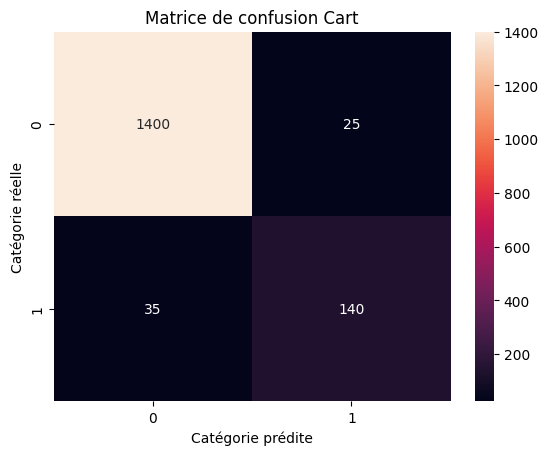

In [48]:
cm(Y_test,tree.predict(X_test),'Matrice de confusion Cart')

La méthode fonctionne ici très bien. Seulement 54 prélèvements d'eau ont été mal prédits.

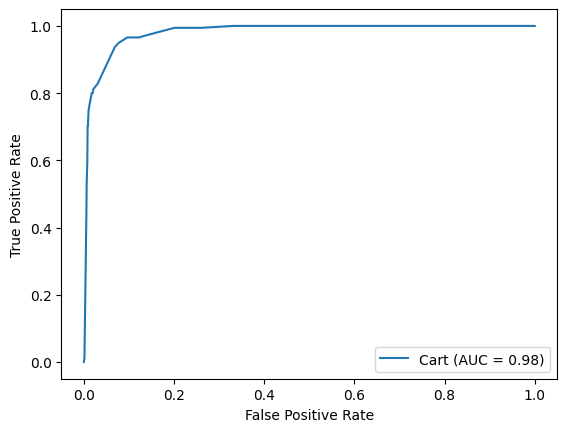

In [36]:
courbe_roc(Y_test,tree.predict_proba(X_test)[:,1],"Cart")

On est à 98% de bonnes prédictions. Le modèle est bon.

## V) RandomForest

Le RandomForest est un ensemble d'arbres de type CART, dont la prédiction se fait grâce au calcul du votes des arbres entrainés. On affectera la classe de sortie à la classe dont le vote a été majoritaire.

### Hyperparamètres RF

In [37]:
from sklearn.ensemble import RandomForestClassifier

#param_grid = { 'n_estimators' : [100,200,300,400,500,600],
#               'max_depth' : [10, 20, 30, None],
#               'criterion' : ('gini','entropy','log_loss')}

#rf = GridSearchCV(RandomForestClassifier(), param_grid)

#print(rf.best_estimator_)
#print(rf.best_params_)

########################
#RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=500)
#{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 500}
########################     
rf = RandomForestClassifier(n_estimators = 500, max_depth = 20, criterion = 'entropy')
rf.fit(X_train,Y_train)


RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=500)

### Matrice de confusion RF 

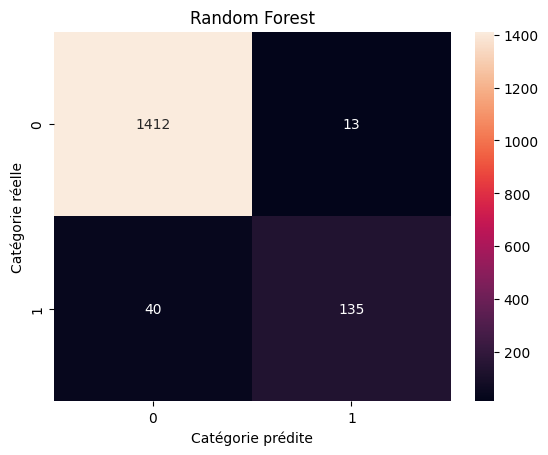

In [49]:
cm(Y_test,rf.predict(X_test),'Random Forest')

### Courbe ROC RF

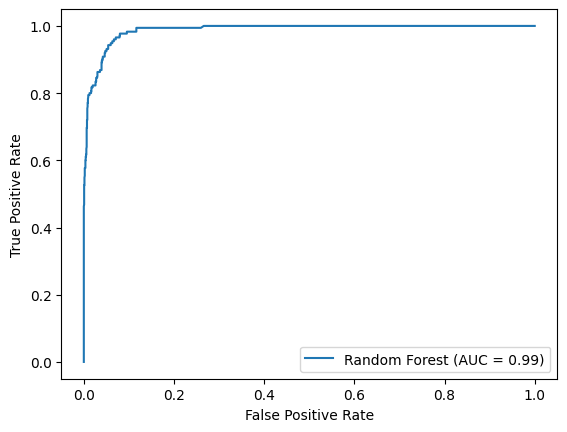

In [50]:
courbe_roc(Y_test,rf.predict_proba(X_test)[:,1],"Random Forest")

Doute sur la valeur de l'auc ici, 99% de bonnes prédictions sur les random forest. 

## VI) Les SVM

Les Supports Vector Machines sont aussi des méthodes à séparation linéaires. On cherche les paramètre optimaux sur le jeu d'entrainement :

In [63]:
param_grid = { 'kernel' : ('linear','rbf'),
    'C': [1e-2, 1e-1, 5e-1, 1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
              }
svm = GridSearchCV(SVC(probability=True), param_grid)
svm = svm.fit(X_train, Y_train.astype("category"))
print(svm.best_estimator_)


SVC(C=1, gamma=0.0001, kernel='linear', probability=True)


### Hyperparamètres SVM

In [74]:
svm = SVC(C=1, gamma=0.0001, kernel='linear', probability=True)
svm = svm.fit(X_train, Y_train.astype("category"))

In [68]:
svm.predict(X_test)

array(['0', '0', '0', ..., '0', '0', '0'], dtype=object)

### Matrice de confusion

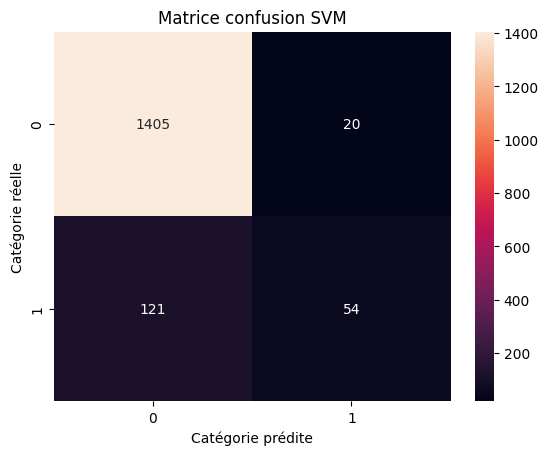

In [69]:
cm(Y_test,svm.predict(X_test),'Matrice confusion SVM')

### Courbe ROC SVM 

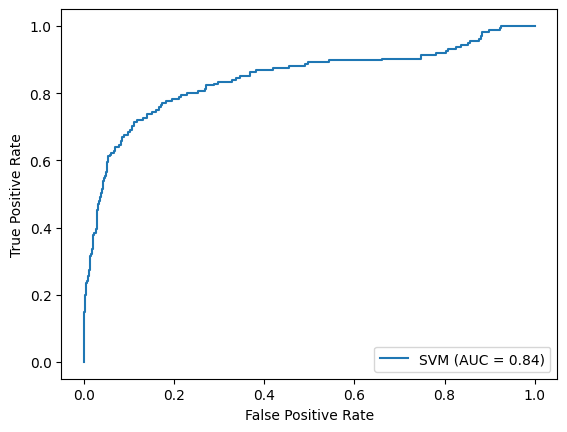

In [57]:
courbe_roc(Y_test,svm.predict_proba(X_test)[:,1],'SVM')

84% de bonnes prédictions.

# VII) Méthode du Super-Learner

Les 4 méthodes donnent de bons résultats, et on souhaite si le fait de les associer entre eux augmente notre pouvoir prédictif.
Pour réaliser cette étude, on récupère les probabilités, pour chaque modèle, d'appartenir à la classe 1.
L'objectif est d'utiliser ses variables comme variables dans une regression logistique.
On obtiendra ainsi une nouvelle probabilité d'appartenir à la classe 1, qui reprendra l'ensemble des prédictions des classifieurs précédents.

In [58]:
df = pd.DataFrame({'Log' : model1.predict_proba(X_train)[:,1], 'Cart' : tree.predict_proba(X_train)[:,1], 'Random forest' : rf.predict_proba(X_train)[:,1], 'SVM' : svm.predict_proba(X_train)[:,1]})
df_df = pd.DataFrame({'Log' : model1.predict_proba(X_test)[:,1], 'Cart' : tree.predict_proba(X_test)[:,1], 'Random forest' : rf.predict_proba(X_test)[:,1], 'SVM' : svm.predict_proba(X_test)[:,1]})

model2 = LogisticRegression(random_state = 0, penalty = "none", fit_intercept = True, max_iter = 10000)
model2.fit(df,Y_train)

model2.coef_

array([[-1.10543164, -4.65584798, 58.32885339, -4.6340157 ]])

### Matrice de confusion
On observe un coefficient très grand pour les random forest, et négatifs pour les autres classifieurs. Le superlearner va se baser sur la prédiction des random forest, et est ici même perturbé 

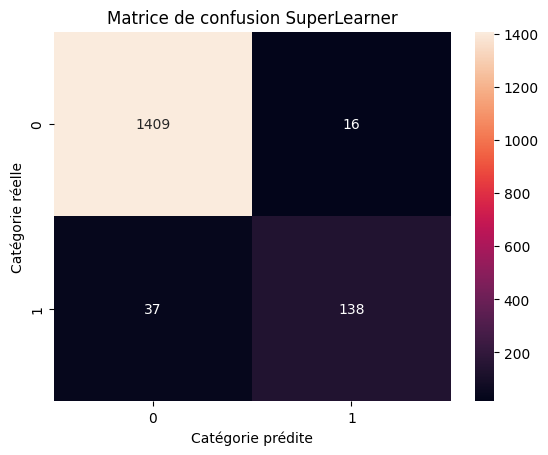

In [62]:
cm(Y_test,model2.predict(df_df),'Matrice de confusion SuperLearner')

### Courbe ROC  


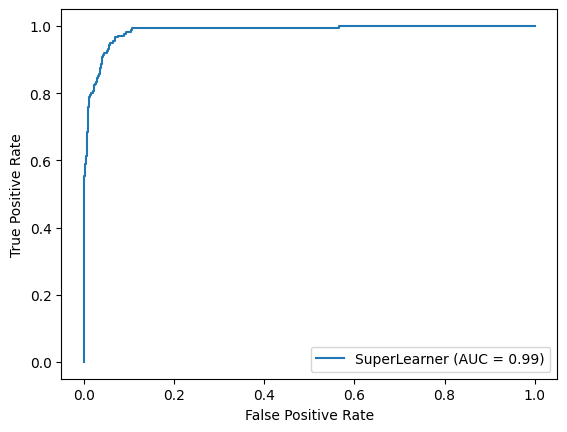

In [63]:
courbe_roc(Y_test,model2.predict_proba(df_df)[:,1],'SuperLearner')

# Conclusion

Pour conclure l'étude, les 4 algorithmes utilisés donnent de bons résultats. Les randoms forest devancent quand mêmes les autres algorithmes et la méthode du super learner va suivre sa décision.
Dans cette réalisation, le superlearner réduit le nombre d'erreur sur les eaux prédites non saines à tort, mais en revanche fait pire sur la prédiction à tort d'une eau saine, alors que celle ci ne l'est pas.
Dans cette étude, on chercherait à minimiser l'erreur de prédire à tort une eau saine, ce qui pourrait être dramatique s'il y a exposition ou ingestion.
